In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [4]:
XAUUSD = load_data()

In [16]:
data_1 = XAUUSD['D1'].copy()

In [17]:
data_2 = pd.read_csv(
    PATH_DATA + '/USDJPY/USDJPY_D1 - USDJPY_D1' + '.csv', index_col='Time', parse_dates=True)

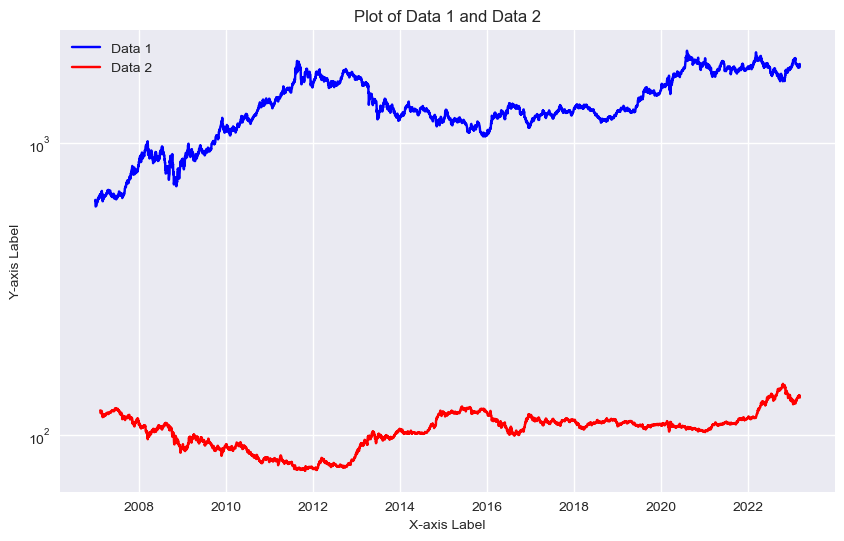

In [9]:
plt.figure(figsize=(10, 6))

# พล็อตข้อมูลใน data_1
plt.plot(data_1.index, data_1['Close'], label='Data 1', color='blue')
plt.yscale('log')  # ใช้ค่าลอการิทึมในแกน y

# พล็อตข้อมูลใน data_2
plt.plot(data_2.index, data_2['Close'], label='Data 2', color='red')
plt.yscale('log')  # ใช้ค่าลอการิทึมในแกน y

# เพิ่มคำอธิบายแต่ละแท่งของกราฟ
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Plot of Data 1 and Data 2')
plt.legend()

# แสดงกราฟ
plt.show()

In [29]:
import statsmodels.api as sm
from pykalman import KalmanFilter

In [23]:
data_1 = data_1.reindex(data_2.index, method='ffill')  # fill forward

In [24]:
data_1

,Open,High,Low,Close,Volume
Time,,,,,
2007-02-12,666.520,666.898,659.061,660.524,1329
2007-02-13,660.511,668.870,659.846,663.033,1353
2007-02-14,663.468,671.708,663.013,668.469,1333
2007-02-15,668.441,670.400,661.906,667.930,1332
2007-02-16,668.023,669.348,662.058,668.094,1187
...,...,...,...,...,...
2023-03-06,1852.255,1858.168,1845.015,1846.255,1380
2023-03-07,1846.225,1851.555,1812.655,1813.865,1380
2023-03-08,1813.855,1824.185,1809.248,1815.175,1379


In [28]:
data_2

,Open,High,Low,Close,Volume
Time,,,,,
2007-02-12,121.900,121.953,121.730,121.764,64849
2007-02-13,121.760,121.766,121.090,121.263,618320
2007-02-14,121.272,121.347,120.226,120.286,616539
2007-02-15,120.282,120.359,119.147,119.376,617115
2007-02-16,119.370,119.550,118.984,119.392,586044
...,...,...,...,...,...
2023-03-06,136.016,136.190,135.364,135.995,506836
2023-03-07,135.995,137.438,135.537,137.387,595894
2023-03-08,137.392,137.910,136.477,137.223,528313


In [27]:
model = sm.OLS(data_1['Close'],data_2['Close'])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Close   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                          5.972e+04
Date:                Sat, 23 Dec 2023   Prob (F-statistic):                        0.00
Time:                        17:00:24   Log-Likelihood:                         -37037.
No. Observations:                5021   AIC:                                  7.408e+04
Df Residuals:                    5020   BIC:                                  7.408e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Close         12.5893      0.052    244.371      0.000      12.488      12.690
==============================================================================
Omnibus:                       64.002   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.023
Skew:                          -0.016   Prob(JB):                     3.36e-09
Kurtosis:                       2.569   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

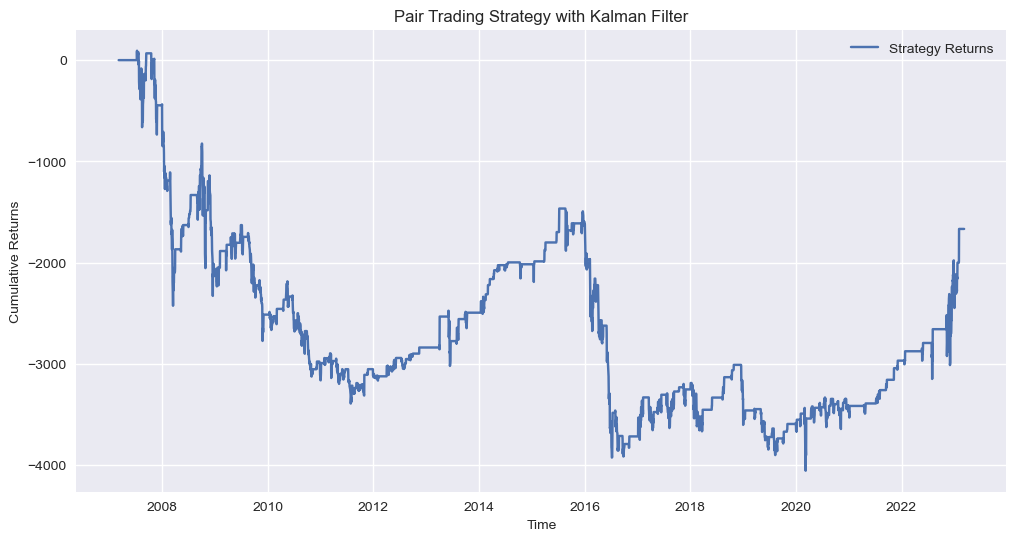

In [31]:


# Combine prices into a DataFrame
data = data_1

# Implementing Kalman Filter for the pair of stocks
delta = 1e-4
trans_cov = delta / (1 - delta) * np.eye(2)
obs_mat = np.vstack([data_1['Close'], np.ones(data_1['Close'].shape)]).T[:, np.newaxis]
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=0,
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=.0001)

state_means, _ = kf.filter(data_2['Close'].values)

data['Hedge_Ratio'] = -state_means[:, 0]

# Simple pairs trading strategy
data['Spread'] = data_2['Close'] - data['Hedge_Ratio'] * data_2['Close']
data['Spread_Mean'] = data['Spread'].rolling(
    window=20).mean()  # Rolling mean of spread
data['Spread_STD'] = data['Spread'].rolling(
    window=20).std()    # Rolling standard deviation of spread

data['Z_Score'] = (data['Spread'] - data['Spread_Mean']) / data['Spread_STD']

data['Long_Entry'] = data['Z_Score'] < -1.0
data['Long_Exit'] = data['Z_Score'] > -0.5

# Backtest
data['Position'] = np.nan
data.loc[data['Long_Entry'], 'Position'] = 1
data.loc[data['Long_Exit'], 'Position'] = 0
data['Position'] = data['Position'].fillna(method='ffill')

data['Returns'] = data['Position'].shift(
    1) * (data['Spread'] - data['Spread'].shift(1))

# Calculate cumulative returns
data['Cumulative_Returns'] = data['Returns'].cumsum()

# Plotting

plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Returns'], label='Strategy Returns')
plt.title('Pair Trading Strategy with Kalman Filter')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()